In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pdvega

import rustacean_report

pd.set_option('display.max_colwidth', -1)
plt.style.use('ggplot')

In [3]:
%matplotlib inline

# Number of Packages

In [105]:
def load_number_of_packages(path):
    df = pd.read_csv(path, names = ['author_date_time', 'commit', 'package_count'])
    df['author_date_time'] = pd.to_datetime(df['author_date_time'])
    df = df.set_index('author_date_time')
    return df

In [5]:
df = pd.concat([load_number_of_packages('master.csv'),load_number_of_packages('snapshot-2018-09-26.csv')])
df['delta'] = df.package_count.diff(-1)

In [6]:
df_m = df.resample('M').agg('max')
df_m = df_m.reset_index()
df_m['author_date_time'] = df_m['author_date_time'].dt.strftime('%Y-%m-%d')
df_m[['author_date_time', 'package_count', 'delta']].to_json('data/package-count.json', orient='records')

# Number of Revisions and Dependencies

In [106]:
! python package-deps.py > all-packages.json

In [107]:
df = pd.read_json('all-packages.json', orient = 'records', lines = True)

In [78]:
for kind in rustacean_report.DEP_KINDS:
    df['deps_count_' + kind] = df['deps_' + kind].str.len()

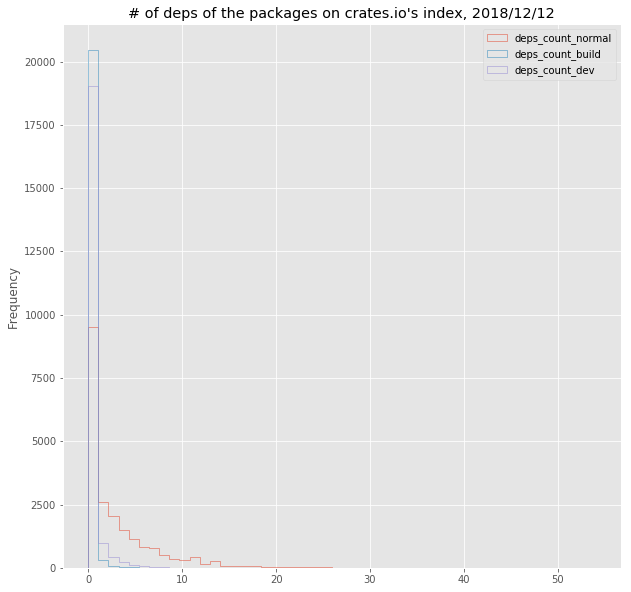

In [95]:
ax = df.fillna(0)[(df.revisions > 0)][['package', 'deps_count_normal', 'deps_count_build', 'deps_count_dev']].plot.hist(
    bins = 50, figsize = (10,10), 
    title = "# of deps of the packages on crates.io's index, 2018/12/12",
    histtype = 'step'
)

In [114]:
ax.figure.savefig('deps-hist.png', dpi = 200)

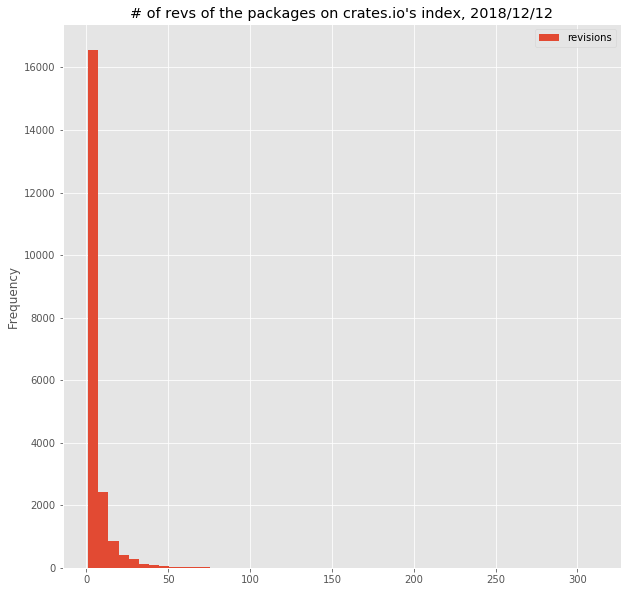

In [115]:
ax = df[['package', 'revisions']].plot.hist(bins = 50, figsize = (10,10), title = "# of revs of the packages on crates.io's index, 2018/12/12")

In [116]:
ax.figure.savefig('revs-hist.png', dpi = 200)

# Number of Clients

In [101]:
reload(rustacean_report)
df = df.set_index('package')
df_clients = rustacean_report.collect_clients(df)

In [104]:
df_clients.sort_values('clients_count_build', ascending = False)[['clients_count_build']]

,clients_count_build
pkg-config,286
bindgen,256
cc,217
gcc,215
serde_codegen,76
cmake,73
rustc_version,72
skeptic,46
syntex,43
lalrpop,34


In [3]:
def crates_io_dow(df):
    result = df.copy()
    result['author_date_time'] = pd.to_datetime(df['author_date_time'])
    result = result.resample('H', on = 'author_date_time').count()
    result = result[['commit']].reset_index()
    
    # Pandas' 0 is Monday whereas strftime's 0 is Sunday
    result['dow'] = (result['author_date_time'].dt.weekday + 1) % 7
    result['dow_hour'] = result['author_date_time'].dt.strftime('%w-%H')
    
    return result

In [4]:
! GIT_DIR=repos/crates.io-index/.git git log \
  --format=%aI,%h 'snapshot-2018-09-26' --after '2018-01-01T00:00:00' > git-log-snapshot-2018-1.csv

In [5]:
! GIT_DIR=repos/crates.io-index/.git git log \
  --format=%aI,%h master --after '2018-01-01T00:00:00' > git-log-snapshot-2018-2.csv

In [6]:
df1 = pd.read_csv('git-log-snapshot-2018-1.csv', names = ['author_date_time', 'commit'])
df2 = pd.read_csv('git-log-snapshot-2018-2.csv', names = ['author_date_time', 'commit'])
df = crates_io_dow(pd.concat([df1, df2]))
df

,author_date_time,commit,dow,dow_hour
0,2018-01-01 08:00:00,2,1,1-08
1,2018-01-01 09:00:00,2,1,1-09
2,2018-01-01 10:00:00,2,1,1-10
3,2018-01-01 11:00:00,0,1,1-11
4,2018-01-01 12:00:00,7,1,1-12
5,2018-01-01 13:00:00,4,1,1-13
6,2018-01-01 14:00:00,3,1,1-14
7,2018-01-01 15:00:00,6,1,1-15
8,2018-01-01 16:00:00,1,1,1-16
9,2018-01-01 17:00:00,1,1,1-17


In [7]:
df

,author_date_time,commit,dow,dow_hour
0,2018-01-01 08:00:00,2,1,1-08
1,2018-01-01 09:00:00,2,1,1-09
2,2018-01-01 10:00:00,2,1,1-10
3,2018-01-01 11:00:00,0,1,1-11
4,2018-01-01 12:00:00,7,1,1-12
5,2018-01-01 13:00:00,4,1,1-13
6,2018-01-01 14:00:00,3,1,1-14
7,2018-01-01 15:00:00,6,1,1-15
8,2018-01-01 16:00:00,1,1,1-16
9,2018-01-01 17:00:00,1,1,1-17


In [14]:
ax = df.groupby('dow').sum()[['commit']].plot.bar(figsize = (20,5),
                                                  title = "# of commits on crates.io's index, per day of the week (0 = Sunday UTC), 2018")

KeyError: 'dow'

In [320]:
ax.figure.savefig('2018-dow.png', dpi = 200)

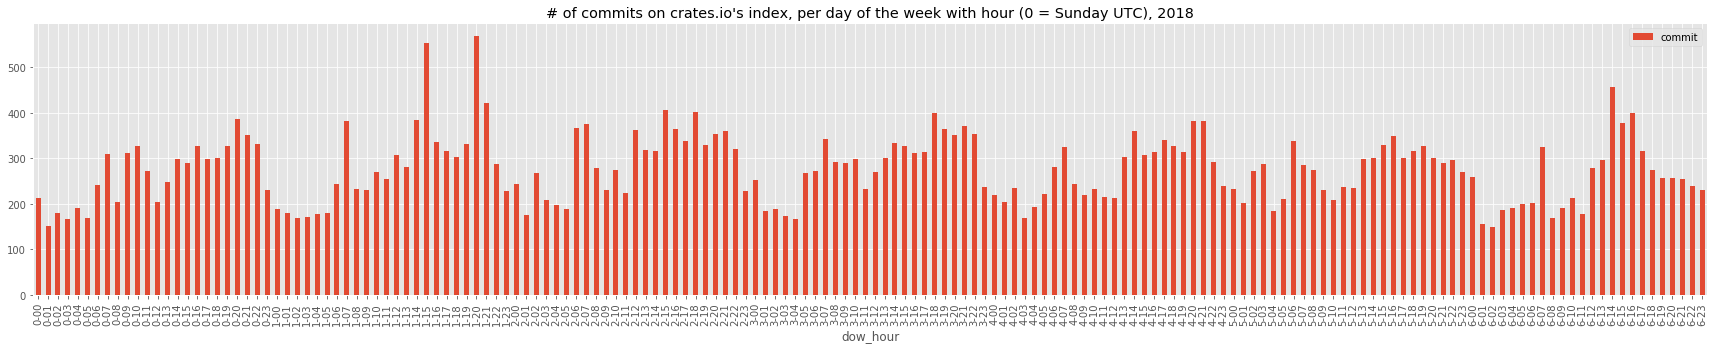

In [321]:
ax = df.groupby('dow_hour').sum()[['commit']].plot.bar(figsize = (30,5), title = "# of commits on crates.io's index, per day of the week with hour (0 = Sunday UTC), 2018")

In [322]:
ax.figure.savefig('2018-dow-with-hour.png', dpi = 200)

In [323]:
! GIT_DIR=repos/crates.io-index/.git git log \
  --format=%aI,%h 'snapshot-2018-09-26' \
  --after '2017-01-01T00:00:00' --before '2018-01-01T00:00:00' > git-log-snapshot-2017.csv

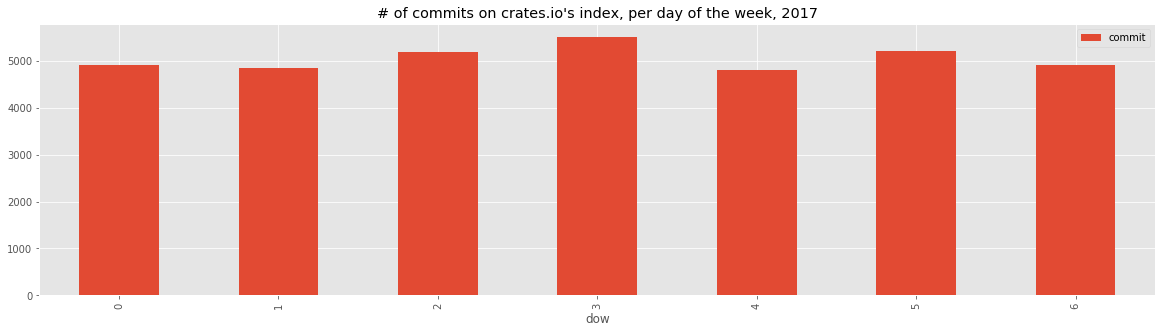

In [324]:
df = pd.read_csv('git-log-snapshot-2017.csv', names = ['author_date_time', 'commit'])
df = crates_io_dow(df)
df.groupby('dow').sum()[['commit']].plot.bar(figsize = (20,5), title = "# of commits on crates.io's index, per day of the week, 2017")

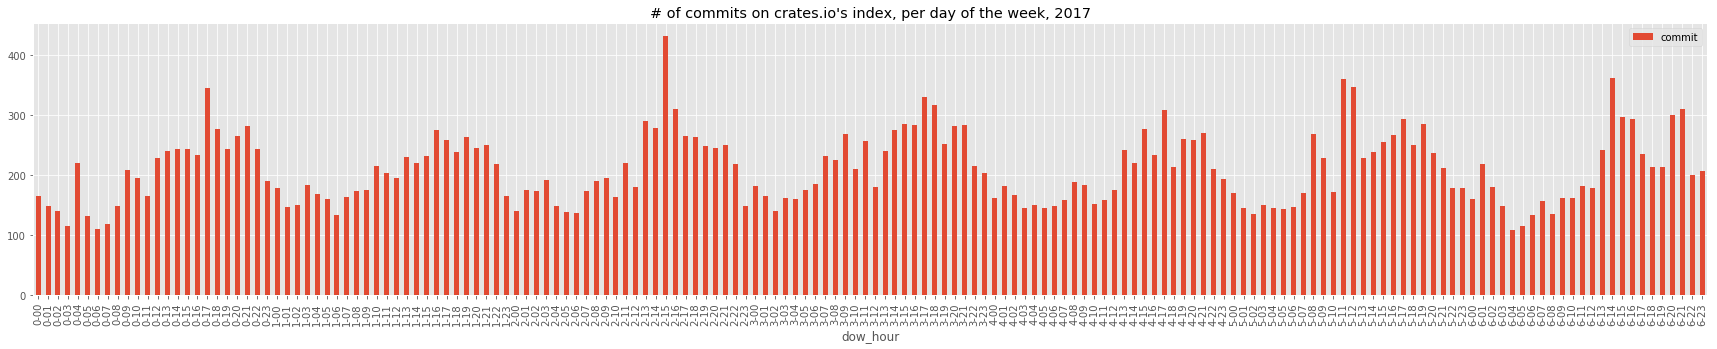

In [325]:
df.groupby('dow_hour').sum()[['commit']].plot.bar(figsize = (30,5), title = "# of commits on crates.io's index, per day of the week, 2017")

In [305]:
! GIT_DIR=repos/crates.io-index/.git git log \
  --format=%aI,%h 'snapshot-2018-09-26' \
  --after '2016-01-01T00:00:00' --before '2017-01-01T00:00:00' > git-log-snapshot-2016.csv

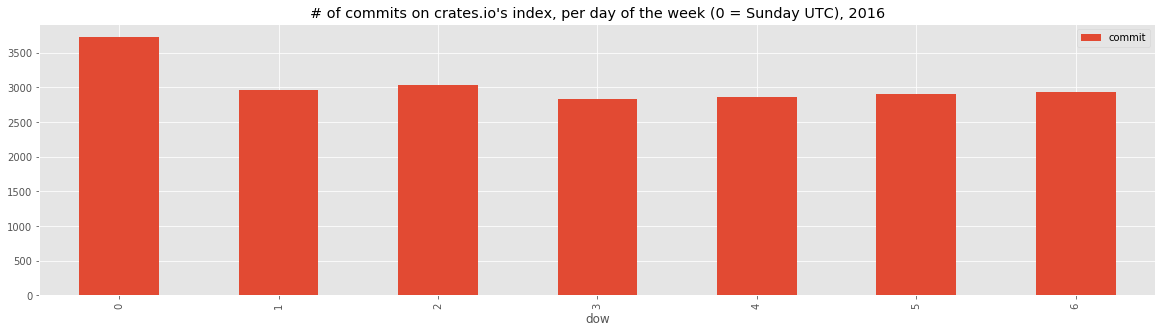

In [332]:
df = pd.read_csv('git-log-snapshot-2016.csv', names = ['author_date_time', 'commit'])
df = crates_io_dow(df)
ax = df.groupby('dow').sum()[['commit']].plot.bar(figsize = (20,5),
                                             title = "# of commits on crates.io's index, per day of the week (0 = Sunday UTC), 2016")

In [307]:
ax.figure.savefig('2016-dow.png', dpi = 200)

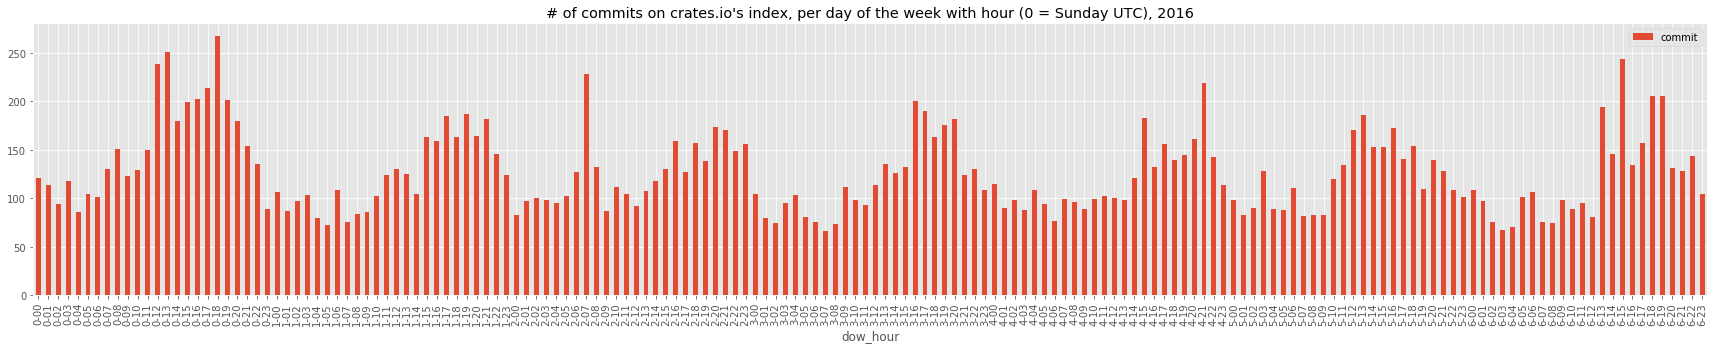

In [308]:
ax = df.groupby('dow_hour').sum()[['commit']].plot.bar(figsize = (30,5),
                                                  title = "# of commits on crates.io's index, per day of the week with hour (0 = Sunday UTC), 2016")

In [309]:
ax.figure.savefig('2016-dow-with-hour.png', dpi = 200)

In [310]:
! GIT_DIR=repos/crates.io-index/.git git log \
  --format=%aI,%h 'snapshot-2018-09-26' \
  --after '2015-01-01T00:00:00' --before '2016-01-01T00:00:00' > git-log-snapshot-2015.csv

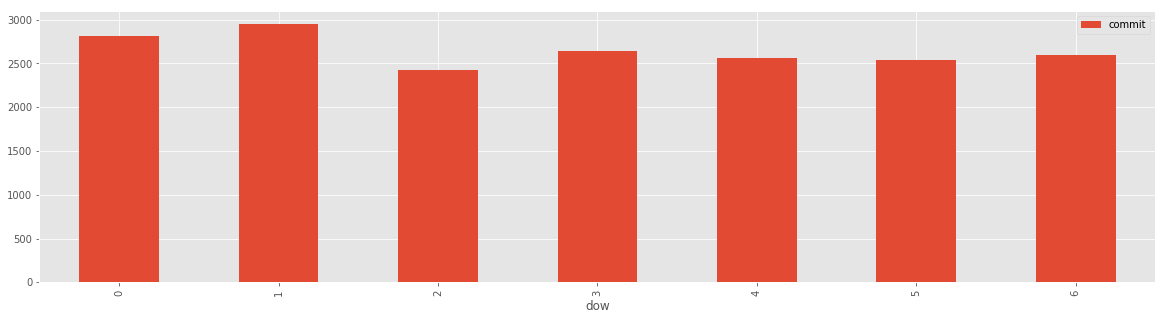

In [331]:
df = pd.read_csv('git-log-snapshot-2015.csv', names = ['author_date_time', 'commit'])
df = crates_io_dow(df)
ax = df.groupby('dow').sum()[['commit']].plot.bar(figsize = (20,5))

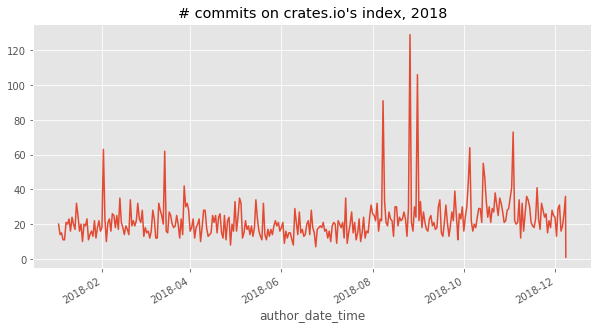

In [33]:
ax = df['delta'].plot(title = "# commits on crates.io's index, 2018", figsize = (10,5))

In [34]:
ax.figure.savefig('delta.png', dpi = 200)

In [37]:
df = df.reset_index()
df['weekday'] = df['author_date_time'].dt.weekday

In [45]:
df

,index,author_date_time,commit,package_count,delta,weekday
0,0,2018-12-08 05:12:08,cf7e93e097,24160,1.0,5
1,1,2018-12-07 23:41:58,70ef1311bb,24159,36.0,4
2,2,2018-12-06 23:50:19,3a0a1996d2,24123,26.0,3
3,3,2018-12-05 23:50:25,8a7d40451f,24097,19.0,2
4,4,2018-12-04 23:52:00,ce1c4fb09e,24078,16.0,1
5,5,2018-12-03 22:55:13,d7c85ba9a4,24062,31.0,0
6,6,2018-12-02 23:40:03,c06f2c599a,24031,29.0,6
7,7,2018-12-01 23:56:50,177b3842e5,24002,13.0,5
8,8,2018-11-30 23:55:09,801426056b,23989,24.0,4
9,9,2018-11-29 23:53:45,993cb1d15f,23965,25.0,3
